In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from typing import List

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
# read data from spam.csv
sms_data=pd.read_csv('spam.csv',engine='python')
sms_data.pop("Unnamed: 2")
sms_data.pop("Unnamed: 3")
sms_data.pop("Unnamed: 4")
sms_data.columns = ['label', 'content']
sms_data.head()

,label,content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# check how many spams and hams
sms_data['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [4]:
# change label to from string to number
# "ham" --> 0, "spam" --> 1

mapping = {'ham': 0,'spam': 1} 
  
sms_data.label = [mapping[item] for item in sms_data.label] 

sms_data.head()

,label,content
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# 切分資料
# 將資料依據label比例切分為training data與testing data
sms_train, sms_test = train_test_split(sms_data,test_size=0.2)

print(sms_train.groupby("label").count())
print(sms_test.groupby("label").count())

       content
label         
0         3865
1          592
       content
label         
0          960
1          155


In [6]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    
    df['content'] = df['content'].str.lower()
    df['content'] = df['content'].str.replace('[^a-zA-Z]',' ')
    
    return df

processed_train = preprocess(sms_train)
processed_test = preprocess(sms_test)

print("Train:")
print(processed_train.head())
print("Test:")
print(processed_test.head())

Train:
      label                                            content
3963      0              if e timing can  then i go w u lor   
1343      0  crazy ar he s married    like gd looking guys ...
4510      0  sorry i missed you babe  i was up late and sle...
423       1  urgent  your mobile number has been awarded wi...
1520      1  urgent  your mobile no was awarded a        bo...
Test:
      label                                            content
3409      0  joy s father is john  then john is the      of...
3186      0                            howz that persons story
1442      0             its ok   i just askd did u knw tht no 
3097      0           this is all just creepy and crazy to me 
3599      0                          i know you mood off today


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [7]:
# split data into x_train, y_train, x_test, y_test
y_train, x_train = zip(*processed_train.values)
y_test, x_test = zip(*processed_test.values)

# check numbers of unique word in the corpus
len(set(" ".join(list(x_train + x_test)).split()))

7708

In [8]:
# TF-IDF
#使用TF-IDF將來選取最高分的前2000個字詞
from sklearn.feature_extraction.text import TfidfVectorizer

# max_df=0.5 單詞如果在50%以上的文件出現就不考慮
# min_df=5 單詞如果出現次數少於5次就不考慮, min_df=0.1 單詞如果在10%以下的文件中出現就不考慮
vectorizer = TfidfVectorizer(max_features=2000) 
## 用X_train來build 字典，字數還有document 數量
vectorizer.fit(x_train)

## 得到tfidf vector
tfidf_train = vectorizer.transform(x_train)
tfidf_test = vectorizer.transform(x_test)

print(f"Number of unique word: {len(vectorizer.vocabulary_)}")
(tfidf_train, tfidf_test)

Number of unique word: 2000


(<4457x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 51017 stored elements in Compressed Sparse Row format>,
 <1115x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 12467 stored elements in Compressed Sparse Row format>)

In [9]:
def create_co_matrix(corpus: List[str], vocab_list: List[str], word2idx: dict,
                     window_size: int=1, use_weighting: bool=False, verbose: bool=False) -> np.ndarray:
    '''Function to create co-occurrence matrix
    '''
    #initialize co-occurrence matrix
    co_matrix = np.zeros(shape=(len(word2idx), len(word2idx)), dtype=np.int32)
    
    for idx, sms in enumerate(corpus):
        #sms = yay can t wait to party together
        processed_sentence = []
        sentence = sms.split(' ')
        for word in sentence:
            if word in word2idx:
                processed_sentence.append(word)

        #將文本轉為ID型式
        sms_ids= []
        for sentence in processed_sentence:
            sms_ids.append(word2idx[sentence])
        
        for center_i, center_word_id in enumerate(sms_ids):
            left_idx = center_i - window_size if center_i - window_size >= 0 else 0
            context_ids = sms_ids[left_idx:center_i]
            
            for left_i, left_word_id in enumerate(context_ids):
                co_matrix[center_word_id, left_word_id] += 1
                co_matrix[left_word_id, center_word_id] += 1
        
        if verbose:
            if idx != 0 and idx%500 == 0:
                    print(f"finishing {idx+1}/{len(corpus)}")
    print("Done")
    if use_weighting:
        # if use weighting, then we set the co-occurrence with the word itself to 1.0
        np.fill_diagonal(co_matrix, 1)
        
    return co_matrix

co_matrix = create_co_matrix(x_train, vectorizer.get_feature_names(), vectorizer.vocabulary_,
                            window_size=3, use_weighting=True, verbose=True)

co_matrix

finishing 501/4457
finishing 1001/4457
finishing 1501/4457
finishing 2001/4457
finishing 2501/4457
finishing 3001/4457
finishing 3501/4457
finishing 4001/4457
Done


array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [10]:
#定義正向點間互資訊

def ppmi(co_matrix: np.ndarray, eps: float=1e-8, verbose: bool=False):
    M = np.zeros_like(co_matrix, dtype=np.float32)
    N = np.sum(co_matrix)
    S = np.sum(co_matrix, axis=0)
    total = co_matrix.shape[0]*co_matrix.shape[1]

    cnt = 0
    
    for i in range(co_matrix.shape[0]):
        for j in range(co_matrix.shape[1]):
            pmi = np.log2(co_matrix[i, j]*N / (S[i]*S[j] + eps))
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % 10 == 0 or cnt == total:
                    print(f"{cnt}/{total} Done")
    
    return M

ppmi_matrix = ppmi(co_matrix, verbose=False)
ppmi_matrix

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log2
  del sys.path[0]


array([[10.493376,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  9.61223 ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  8.493376, ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  8.820373,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  4.791662,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         7.93316 ]], dtype=float32)

Number of components = 10 and explained variance = 0.8241948632961745
Number of components = 20 and explained variance = 0.8703032606693205
Number of components = 30 and explained variance = 0.8947496188724587
Number of components = 40 and explained variance = 0.910804239049849
Number of components = 50 and explained variance = 0.9231550230280281
Number of components = 60 and explained variance = 0.9325468922314121
Number of components = 70 and explained variance = 0.9399619385901151
Number of components = 80 and explained variance = 0.9461260968834946
Number of components = 90 and explained variance = 0.9512832490549646
Number of components = 100 and explained variance = 0.9556653817698179
Number of components = 110 and explained variance = 0.9594078145829937
Number of components = 120 and explained variance = 0.9625710961035246
Number of components = 130 and explained variance = 0.9653307058230691
Number of components = 140 and explained variance = 0.9678018101673801


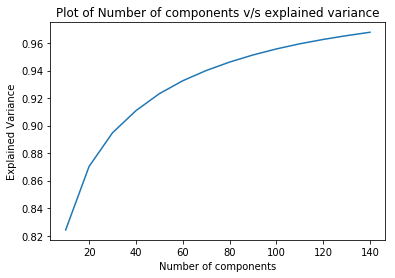

In [11]:
#使用SVD降維
# 利用sklearn中的TruncatedSVD對co-occurrence matrix進行降維，並利用variance來找出最適合的維度 
# Program to find the optimal number of components for Truncated SVD
n_comp = range(10,150,10) # list containing different values of components
variance_sum = [] # explained variance ratio for each component of Truncated SVD

for dim in n_comp:
    svd = TruncatedSVD(n_components=dim)
    svd.fit(co_matrix)
    variance_sum.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(dim,svd.explained_variance_ratio_.sum()))
    
plt.plot(n_comp, variance_sum)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [32]:
# choose 140 as final dimension to reduce to 
# 利用上述找到的最適合dimension來對co-occurrence matrix進行降維
# U, S, V = np.linalg.svd(co_matrix)
# re_co_matrix = U[:, 0:140]
# re_co_matrix

svd = TruncatedSVD(n_components=140)
svd.fit(co_matrix)
re_co_matrix = svd.transform(co_matrix)

In [33]:
# get doc vector via take mean of all word vectors inside the corresponding document

def make_doc_vectors(corpus: List[str], word2idx: dict, vocab_list: List) -> List[np.ndarray]:
    
    # vectorizing data 
    # and make document vector by take mean to all word vecto
    doc_vec = []
    empty_doc_list = []
    for i, sms_msg in enumerate(corpus):
        sms_msg = [word2idx[word] for word in sms_msg.split() if word in vocab_list] #tokenize
        if len(sms_msg) > 0:
            sms_msg = np.array([re_co_matrix[ids] for ids in sms_msg]) #vectorize
            doc_vec.append(sms_msg.mean(axis=0))
        else:
            empty_doc_list.append(i)
            print(f"document {i} doesn't contain word in vocab_list")
            print(corpus[i])
            print("\n")
        
    return np.vstack(doc_vec), empty_doc_list

word2idx = vectorizer.vocabulary_
vocab_list = vectorizer.get_feature_names()

doc_vec_train, missing_train_list = make_doc_vectors(x_train, word2idx, vocab_list)
print("="*50)
doc_vec_test, missing_test_list = make_doc_vectors(x_test, word2idx, vocab_list)

document 608 doesn't contain word in vocab_list
ultimately tor motive tui achieve korli 


document 795 doesn't contain word in vocab_list
ringtoneking      


document 1400 doesn't contain word in vocab_list
       


document 1535 doesn't contain word in vocab_list
s  antha num corrct dane


document 1575 doesn't contain word in vocab_list
k  k   congratulation   


document 1628 doesn't contain word in vocab_list
east coast


document 1857 doesn't contain word in vocab_list
beerage 


document 1903 doesn't contain word in vocab_list
   


document 2227 doesn't contain word in vocab_list
hanks lotsly 


document 2603 doesn't contain word in vocab_list
audrie lousy autocorrect


document 2656 doesn't contain word in vocab_list
raviyog peripherals bhayandar east


document 2816 doesn't contain word in vocab_list
g w r


document 4013 doesn't contain word in vocab_list
       tf   p


document 330 doesn't contain word in vocab_list
garbage bags  eggs  jam  bread  hannaford wheat chex




In [34]:
from sklearn.neighbors import KNeighborsClassifier

# training
y_train_filter = np.delete(np.array(y_train), missing_train_list)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(doc_vec_train, y_train_filter)
train_pred = knn.predict(doc_vec_train)

# testing
y_test_filter = np.delete(np.array(y_test), missing_test_list)
test_pred = knn.predict(doc_vec_test)

In [35]:
print(f"train acc: {np.sum(train_pred == y_train_filter) / len(y_train_filter)}")
print(f"train acc: {np.sum(test_pred == y_test_filter) / len(y_test_filter)}")

train acc: 0.9736723672367237
train acc: 0.9567956795679567
